In [1]:
import numpy as np
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
import copy 
from ucimlrepo import fetch_ucirepo 

import torch
import torch.nn as nn
import torch.optim as optim
from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, matthews_corrcoef
from sklearn.model_selection import train_test_split

from significance_tests import compare_models, perform_t_tests
from ltn_imp.automation.knowledge_base import KnowledgeBase

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import random 
random.seed(42)

In [4]:
data = pd.read_csv("datasets/pima_indians_imputed.csv", index_col=0).astype(np.float32)
data.to_csv("datasets/pertubrated.csv")

# Prepare Dataset

In [5]:
# İgnore 
data = pd.read_csv("datasets/pima_indians_imputed.csv", index_col=0).astype(np.float32)
data["DiabetesPedigreeFunction"] =  data["DiabetesPedigreeFunction"] * 100
data["Pregnancies"] = data["Pregnancies"] * 10

In [6]:
def prepare_datasets(data, random_seed=42):    
    X = data.drop("Outcome", axis=1)  # Features
    y = data["Outcome"]  # Labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_seed, stratify=y)    
    X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed, stratify=y_train)

    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)
    val_data = pd.concat([X_val, y_val], axis=1)
    train_data_ = pd.concat([X_train_, y_train_], axis=1)

    train_data_.to_csv("datasets/train.csv", index=False)
    test_data.to_csv("datasets/test.csv", index=False)
    val_data.to_csv("datasets/val.csv", index=False)

    return train_data, test_data

In [ ]:
train, test = prepare_datasets(data)
print(train.shape)
print(test.shape)

In [ ]:
data.value_counts("Outcome")

# Best Hyper-Parameters

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def find_best_models(X,y):
    param_grid = {

        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]
            }
        },

        'DT': {
            'model': DecisionTreeClassifier(),
            'params': {
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'criterion': ['gini', 'entropy']
            }
        },

        'RF': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5],
                'criterion': ['gini', 'entropy']
            }
        },
        
        'LR': {
            'model': LogisticRegression(max_iter=1000),
            'params': {
                'C': [0.1, 1, 10],
                'solver': ['lbfgs', 'liblinear']
            }
        }
    }

    best_models = {}
    for name, model_info in param_grid.items():
        grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=5, n_jobs=-1)
        grid_search.fit(X, y)
        best_models[name] = grid_search.best_estimator_

    models = []
    for name, model in best_models.items():
        if name == 'LR':
            models.append(LogisticRegression(**model.get_params()))
        elif name == 'KNN':
            models.append(KNeighborsClassifier(**model.get_params()))
        elif name == 'DT':
            models.append(DecisionTreeClassifier(**model.get_params()))
        elif name == 'RF':
            models.append(RandomForestClassifier(**model.get_params()))

    return models

# Train and Evaluate Models

In [ ]:
kb = KnowledgeBase("config.yaml")
models = find_best_models(train.drop("Outcome", axis=1), train["Outcome"])
models.append(kb.predicates["Diabetic"])

In [11]:
model_names = ['KNN',
 'Decision Tree',
 'Random Forest',
 'Logistic Regression',
 'MLP',
 'Logic Tensor Network']

In [12]:
columns = train.columns[:-1]
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC"]

In [13]:
device = torch.device("cpu")

def predict(model, x):

    if hasattr(model, 'predict'):
        if isinstance(x, torch.Tensor):
            x = x.cpu().numpy()
        preds = model.predict(x)
        return torch.tensor(preds, dtype=torch.float32)
    
    model.eval() 

    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    elif x.dtype != torch.float32:
        x = x.float()

    with torch.no_grad():  
        probs = model(x)
        preds = (probs > 0.5).float()

    return preds

def evaluate_model(loader, model, device):
    all_true_labels = []
    all_predicted_labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for data, labels in loader:
            # Ensure data and labels are the correct dtype
            if not isinstance(data, torch.Tensor):
                data = torch.tensor(data, dtype=torch.float32)
            elif data.dtype != torch.float32:
                data = data.float()
            
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels, dtype=torch.float32)
            elif labels.dtype != torch.float32:
                labels = labels.float()
            
            # Get predictions
            preds = predict(model, data)

            # Squeeze predictions and labels to remove dimensions of size 1
            predicted_labels = preds.squeeze()
            true_labels = labels.squeeze()

            # Ensure the shapes match before comparison
            if predicted_labels.shape != true_labels.shape:
                true_labels = true_labels.view_as(predicted_labels)
            
            # Collect all predictions and true labels for MCC
            all_true_labels.extend(true_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    true_labels = np.array(all_true_labels)
    predicted_labels = np.array(all_predicted_labels)
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)  # zero_division=0 handles the division by zero case
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)

    try:
        model.train()
    except:
        ""

    return accuracy, precision, recall, f1, balanced_accuracy, mcc

def evaluate_sklearn_model(dataset, model):
    # Assuming the last column is the label
    data = dataset.iloc[:, :-1]  # All columns except the last one are features
    true_labels = dataset.iloc[:, -1]  # The last column is the label

    # Predict using the sklearn model
    predicted_labels = model.predict(data)
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)  
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)

    return accuracy, precision, recall, f1, balanced_accuracy, mcc

# Rule 1: (BMI > 29 and Glucose > 125) -> Diabetic (1)
def rule_1(data_df):
    condition = (data_df['BMI'] > 29) & (data_df['Glucose'] > 125)
    outcome = pd.Series(np.nan, index=data_df.index)
    outcome[condition] = 1  # Diabetic
    return outcome

# Rule 2: (BMI < 26 and Glucose < 101) -> Not Diabetic (0)
def rule_2(data_df):
    condition = (data_df['BMI'] < 26) & (data_df['Glucose'] < 101)
    outcome = pd.Series(np.nan, index=data_df.index)
    outcome[condition] = 0  # Not Diabetic
    return outcome

def rule_adherence(model, test_set):

    if isinstance(test_set, pd.DataFrame):
        X = test_set.iloc[:, :-1].values
    elif isinstance(test_set, np.ndarray):
        X = test_set[:, :-1]
    elif isinstance(test_set, torch.Tensor):
        X = test_set[:, :-1].numpy()

    data_df = pd.DataFrame(X, columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                                       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
    
    preds = predict(model, X).numpy()

    expected_outcome_rule_1 = rule_1(data_df)
    rule_1_indices = expected_outcome_rule_1[~expected_outcome_rule_1.isna()].index

    adherence_rule_1 = 0
    if len(rule_1_indices) > 0:
        relevant_preds_rule_1 = preds[rule_1_indices]
        adherence_rule_1 = np.sum(relevant_preds_rule_1 == 1)
    
    total_rule_1 = len(rule_1_indices)
    adherence_percentage_rule_1 = (adherence_rule_1 / total_rule_1 * 100) if total_rule_1 > 0 else np.nan

    expected_outcome_rule_2 = rule_2(data_df)
    rule_2_indices = expected_outcome_rule_2[~expected_outcome_rule_2.isna()].index

    adherence_rule_2 = 0
    if len(rule_2_indices) > 0:
        relevant_preds_rule_2 = preds[rule_2_indices]
        adherence_rule_2 = np.sum(relevant_preds_rule_2 == 0)
    
    total_rule_2 = len(rule_2_indices)
    adherence_percentage_rule_2 = (adherence_rule_2 / total_rule_2 * 100) if total_rule_2 > 0 else np.nan

    adherence_percentages = {
        'Rule 1': adherence_percentage_rule_1,
        'Rule 2': adherence_percentage_rule_2
    }
    
    return adherence_percentages


In [14]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

    linear_layers = [module for module in model.modules() if isinstance(module, nn.Linear)]

    for layer in linear_layers[-2:]:
        for param in layer.parameters():
            param.requires_grad = True

def train_model(model, kb):

    criteria = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

    patience = 5
    min_delta = 0.0
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(50):
        model.train()
        total_loss = 0.0
        num_batches = 0
        
        # Training loop
        for data, labels in kb.loaders[0]:
            optimizer.zero_grad()
            predictions = model(data)
            loss = criteria(predictions, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1

        avg_train_loss = total_loss / num_batches

        model.eval()
        total_val_loss = 0.0
        num_val_batches = 0

        for data, labels in kb.val_loaders[0]:
            with torch.no_grad():
                predictions = model(data)
                val_loss = criteria(predictions, labels)
                total_val_loss += val_loss.item()
                num_val_batches += 1

        avg_val_loss = total_val_loss / num_val_batches

        # Early stopping logic
        if avg_val_loss + min_delta < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

        model.train()

In [15]:
from examples.medical.diabetes.roboustness import *

metrics_df = pd.DataFrame([ [ [] for _ in metrics ] for _ in model_names ] , columns=metrics, index=[model_names])
adherence_df = pd.DataFrame([ [ [] for _ in range(1, len(kb.rules) - 1) ] for _ in model_names ] , columns=[f"Rule {i}" for i in range(1, len(kb.rules) - 1)], index=[model_names])

pertubrated_names = ["Pertubrated " + model_name for model_name in model_names]
perturbed_df = pd.DataFrame([ [ [] for _ in metrics ] for _ in model_names ] , columns=metrics, index=[pertubrated_names])
kl_divergence_df = pd.DataFrame([[[]] for _ in model_names], columns=["KL Divergence"], index=model_names)

seeds = [seed for seed in range(0, 30)]
data = pd.read_csv("datasets/pima_indians_imputed.csv", index_col=0).astype(np.float32)

for seed in seeds:

    train, test = prepare_datasets(data, seed)
    perturbed_test = apply_combined_perturbations(test, label_column='Outcome', mu=0, sigma=0.1, flip_prob=0.1, seed=seed)
    perturbed_test.to_csv(f"datasets/perturbed.csv", index=False)
    feature_columns = train.columns.drop("Outcome").tolist()
    kl_divergence_score = compute_kl_divergence(test, perturbed_test, feature_columns)

    for i, model in enumerate(models):
        model_name = model_names[i]
        
        if not hasattr(model, "fit"):
            
            kb = KnowledgeBase("config.yaml")            
            model = kb.predicates["Diabetic"]
            train_model(model, kb)
            freeze_model(model.model)        

            metrics_values = evaluate_model(kb.test_loaders[0], model, kb.device)
            adherence_values = rule_adherence(model, test)
            perturbed_values = evaluate_model(kb.test_loaders[1], model, kb.device)

            for metric, value in zip(metrics, metrics_values):
                metrics_df.loc["MLP"][metric][0].append(value)

            for rule, adherence in adherence_values.items():
                adherence_df.loc["MLP"][rule][0].append(adherence)

            for metric, value in zip(metrics, perturbed_values):
                perturbed_df.loc["Pertubrated MLP"][metric][0].append(value)

            kb.optimize(num_epochs=200, lr=0.000001, early_stopping=True, verbose=False)
            metrics_values = evaluate_model(kb.test_loaders[0], kb.predicates["Diabetic"], kb.device)
            adherence_values = rule_adherence(model, test)
            perturbed_values = evaluate_model(kb.test_loaders[1], model, kb.device)

            for metric, value in zip(metrics, metrics_values):
                metrics_df.loc["Logic Tensor Network"][metric][0].append(value)

            for rule, adherence in adherence_values.items():
                adherence_df.loc["Logic Tensor Network"][rule][0].append(adherence)
                            
            for metric, value in zip(metrics, perturbed_values):
                perturbed_df.loc["Pertubrated Logic Tensor Network"][metric][0].append(value)

            kl_divergence_df.loc[model_name]["KL Divergence"].append(kl_divergence_score)

        else:

            model.fit(train.drop("Outcome", axis=1), train["Outcome"])
            metrics_values = evaluate_sklearn_model(test, model)
            adherence_values = rule_adherence(model, test)
            perturbed_values = evaluate_sklearn_model(perturbed_test, model)

            for metric, value in zip(metrics, metrics_values):
                metrics_df.loc[model_name][metric][0].append(value)

            for rule, adherence in adherence_values.items():
                adherence_df.loc[model_name][rule][0].append(adherence)
            
            for metric, value in zip(metrics, perturbed_values):
                perturbed_df.loc["Pertubrated " + model_name][metric][0].append(value)

            kl_divergence_df.loc[model_name]["KL Divergence"].append(kl_divergence_score)

Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu


# Performance Evaluation

## Model Evaluation with 50 Random States

This section evaluates all models across 50 different random states in performance metrics. The following steps are performed:

 ### 1. Box Plot Visualization:  
   Box plots are generated for the evaluation metrics, allowing a clear visual comparison of model performance.
   
   

 ### 2. T-Test Comparisons:  
   Two sets of T-tests are conducted:
   
   - **Best Model Significance Test**:  
     For each evaluation metric, the T-test checks if the best-performing model is significantly better than the others.
   
   - **Comparison with Our Model**:  
     For cases where our model is not the best, it is compared against each of the other models for each metric.


In [16]:
def plot_metrics(metrics_df, metrics_to_plot, x_size = 18, y_size = 4):
    plt.figure(figsize=(x_size, len(metrics_to_plot) * 4))

    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(len(metrics_to_plot), 1, i)
        data_to_plot = [metrics_df.loc[model_name, metric] for model_name in metrics_df.index]
        
        # Customize the boxplots
        boxprops = dict(linewidth=2)
        medianprops = dict(linewidth=2, color='red')
        meanprops = dict(linewidth=2, color='blue')
        whiskerprops = dict(linewidth=2)
        capprops = dict(linewidth=2)
        
        plt.boxplot(data_to_plot, labels=metrics_df.index, boxprops=boxprops, 
                    medianprops=medianprops, meanline=True, showmeans=True, 
                    meanprops=meanprops, whiskerprops=whiskerprops, 
                    capprops=capprops)
        
        plt.title(f'Boxplot of {metric} across different models')
        plt.xlabel('Model', fontweight='bold')
        plt.ylabel(metric, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [17]:
metrics_df.index = model_names

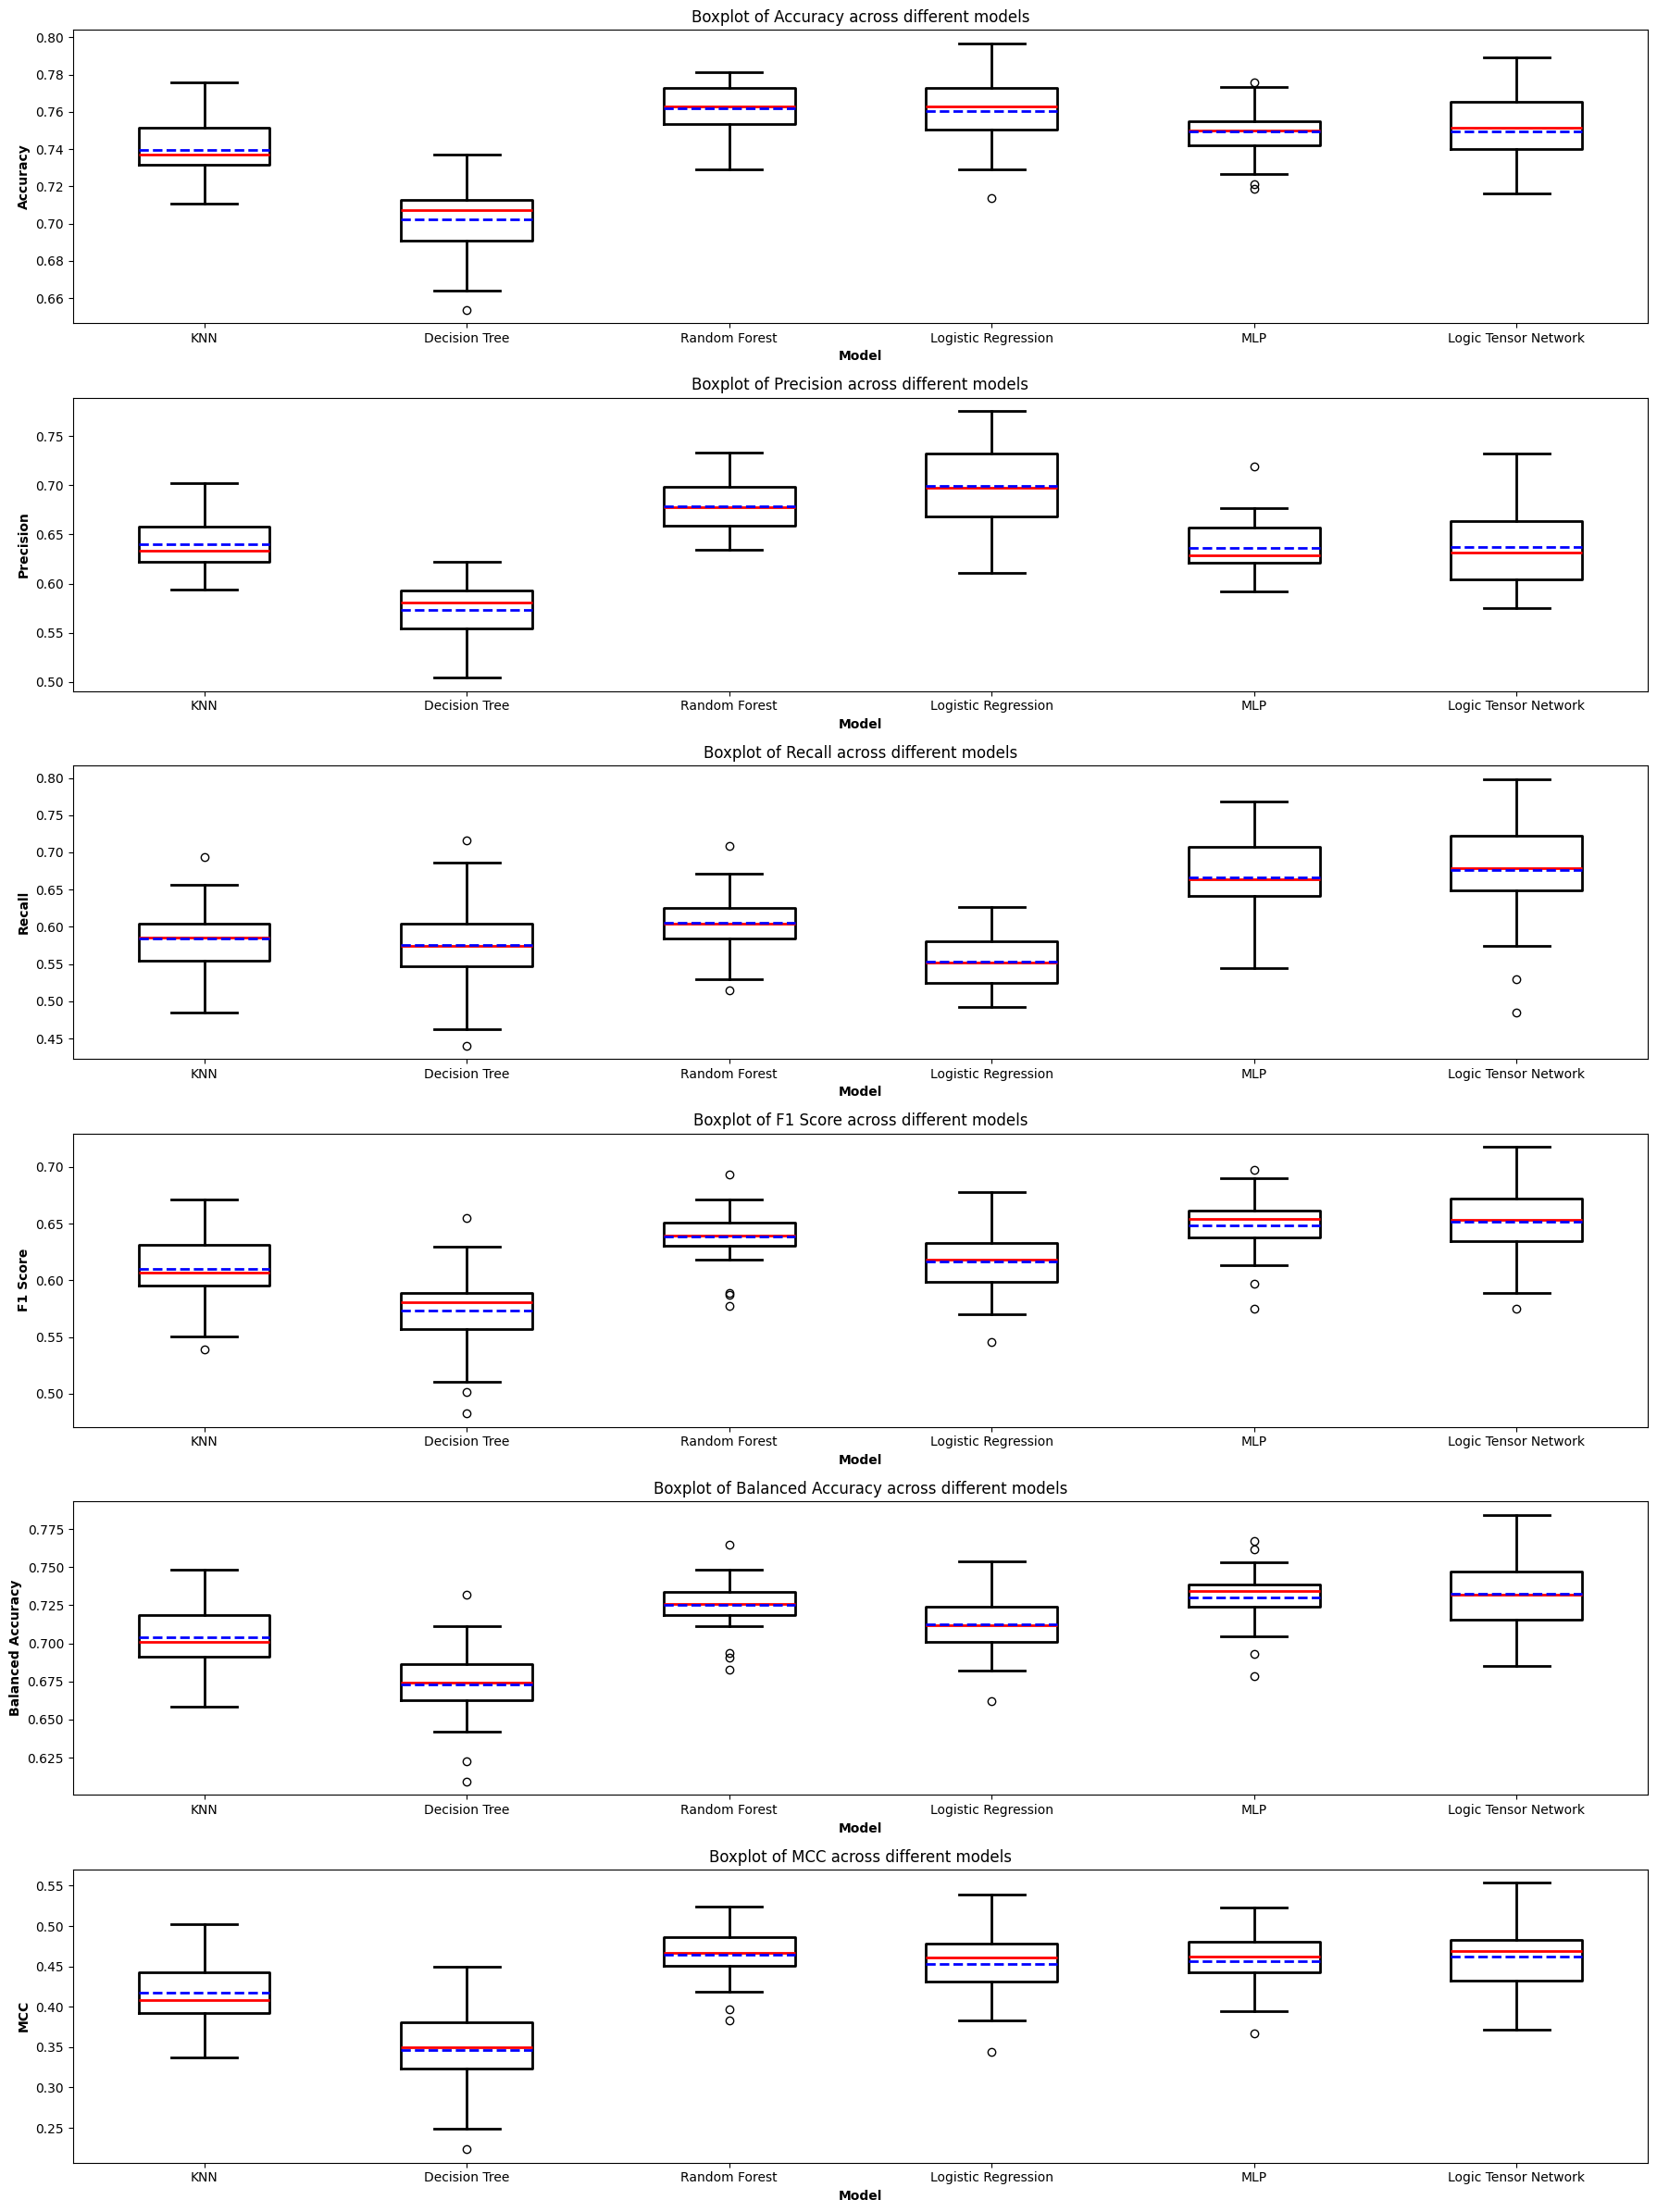

In [18]:
plot_metrics(metrics_df, metrics)

In [19]:
compare_models(metrics_df)


Accuracy:
  Random Forest is significantly better than KNN (adjusted p = 0.0000)
  Random Forest is significantly better than Decision Tree (adjusted p = 0.0000)
  Random Forest is NOT significantly better than Logistic Regression (adjusted p = 1.1035)
  Random Forest is significantly better than MLP (adjusted p = 0.0014)
  Random Forest is significantly better than Logic Tensor Network (adjusted p = 0.0117)

Precision:
  Logistic Regression is significantly better than KNN (adjusted p = 0.0000)
  Logistic Regression is significantly better than Decision Tree (adjusted p = 0.0000)
  Logistic Regression is significantly better than Random Forest (adjusted p = 0.0051)
  Logistic Regression is significantly better than MLP (adjusted p = 0.0000)
  Logistic Regression is significantly better than Logic Tensor Network (adjusted p = 0.0000)

Recall:
  Logic Tensor Network is significantly better than KNN (adjusted p = 0.0000)
  Logic Tensor Network is significantly better than Decision Tree 

In [20]:
for model in metrics_df.index:
    perform_t_tests(metrics_df, model)
    print()
    print( "-" * 100)


Accuracy:
  Logic Tensor Network is significantly better than KNN (adjusted p = 0.0381)

Precision:
  There is no significant difference between Logic Tensor Network and KNN (adjusted p = 3.0196)

Recall:
  Logic Tensor Network is significantly better than KNN (adjusted p = 0.0000)

F1 Score:
  Logic Tensor Network is significantly better than KNN (adjusted p = 0.0000)

Balanced Accuracy:
  Logic Tensor Network is significantly better than KNN (adjusted p = 0.0000)

MCC:
  Logic Tensor Network is significantly better than KNN (adjusted p = 0.0000)

----------------------------------------------------------------------------------------------------

Accuracy:
  Logic Tensor Network is significantly better than Decision Tree (adjusted p = 0.0000)

Precision:
  Logic Tensor Network is significantly better than Decision Tree (adjusted p = 0.0000)

Recall:
  Logic Tensor Network is significantly better than Decision Tree (adjusted p = 0.0000)

F1 Score:
  Logic Tensor Network is significan

In [21]:
mean_df = pd.DataFrame(columns=metrics, index=model_names)

for metric in metrics_df.columns:
    mean_df[metric] = metrics_df[metric].apply(np.mean)

In [22]:
mean_df

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,MCC
KNN,0.739757,0.640068,0.584826,0.610123,0.703813,0.417398
Decision Tree,0.702170,0.573441,0.575871,0.573209,0.672869,0.345922
Random Forest,0.761719,0.678333,0.605721,0.639028,0.725527,0.464578
Logistic Regression,0.760243,0.699531,0.553234,0.616712,0.712217,0.453132
MLP,0.749479,0.636485,0.665920,0.648857,0.730094,0.456753
Logic Tensor Network,0.749653,0.637207,0.676119,0.651919,0.732593,0.461699


# Logic Adherence

## Model Evaluation with 50 Random States

This section evaluates all models across 50 different random states in Logic adherence ( meaning how well aligned are the predictions with the given logic rules ). The following steps are performed:

 ### 1. Box Plot Visualization:  
   Box plots are generated for the evaluation metrics, allowing a clear visual comparison of model performance.
   
   

 ### 2. T-Test Comparisons:  
   Two sets of T-tests are conducted:
   
   - **Best Model Significance Test**:  
     For each rule, the T-test checks if the best-performing model is significantly better than the others.
   
   - **Comparison with Our Model**:  
     For cases where our model is not the best, it is compared against each of the other models for each rule.

### 3. Rules:

  Rule 1: forall person. (((person[BMI] > 29) and (person[Glucose] > 125 )) -> Diabetic(person))"
  
  Rule 2: forall person. (((person[BMI] < 26) and (person[Glucose] < 101 )) -> not Diabetic(person))"



In [23]:
adherence_df.index = model_names

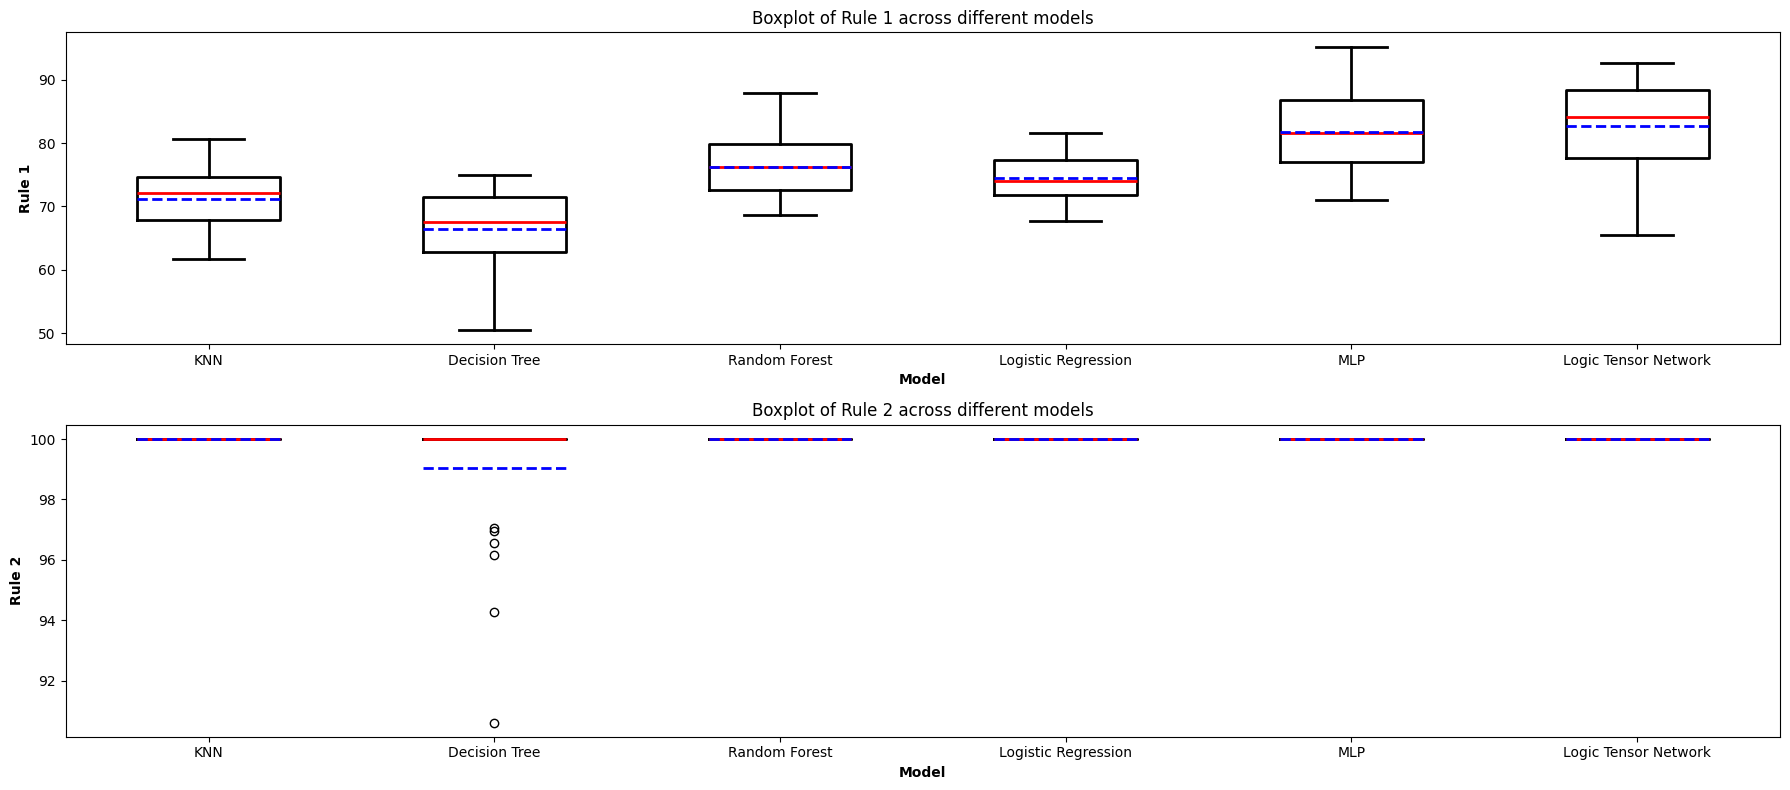

In [24]:
plot_metrics( adherence_df, ["Rule " + str(i) for i in range(1, 3)])

In [25]:
compare_models(adherence_df)

Could not perform Wilcoxon test between KNN and Random Forest for metric Rule 2
Could not perform Wilcoxon test between KNN and Logistic Regression for metric Rule 2
Could not perform Wilcoxon test between KNN and MLP for metric Rule 2
Could not perform Wilcoxon test between KNN and Logic Tensor Network for metric Rule 2

Rule 1:
  Logic Tensor Network is significantly better than KNN (adjusted p = 0.0000)
  Logic Tensor Network is significantly better than Decision Tree (adjusted p = 0.0000)
  Logic Tensor Network is significantly better than Random Forest (adjusted p = 0.0001)
  Logic Tensor Network is significantly better than Logistic Regression (adjusted p = 0.0000)
  Logic Tensor Network is NOT significantly better than MLP (adjusted p = 0.5344)

Rule 2:
  KNN is NOT significantly better than Decision Tree (adjusted p = 0.0693)


In [26]:
for model in metrics_df.index:
    perform_t_tests(adherence_df, model)
    print()
    print( "-" * 100)

Could not perform Wilcoxon test between Logic Tensor Network and KNN for metric Rule 2

Rule 1:
  Logic Tensor Network is significantly better than KNN (adjusted p = 0.0000)

----------------------------------------------------------------------------------------------------

Rule 1:
  Logic Tensor Network is significantly better than Decision Tree (adjusted p = 0.0000)

Rule 2:
  Logic Tensor Network is significantly better than Decision Tree (adjusted p = 0.0139)

----------------------------------------------------------------------------------------------------
Could not perform Wilcoxon test between Logic Tensor Network and Random Forest for metric Rule 2

Rule 1:
  Logic Tensor Network is significantly better than Random Forest (adjusted p = 0.0000)

----------------------------------------------------------------------------------------------------
Could not perform Wilcoxon test between Logic Tensor Network and Logistic Regression for metric Rule 2

Rule 1:
  Logic Tensor Netwo

In [27]:
mean_df = pd.DataFrame(columns=["Rule 1", "Rule 2"], index=model_names)

for metric in adherence_df.columns:
    mean_df[metric] = adherence_df[metric].apply(np.mean)

In [28]:
mean_df

,Rule 1,Rule 2
KNN,71.183512,100.000000
Decision Tree,66.411012,99.054827
Random Forest,76.213613,100.000000
Logistic Regression,74.472790,100.000000
MLP,81.778005,100.000000
Logic Tensor Network,82.674620,100.000000


# QoS

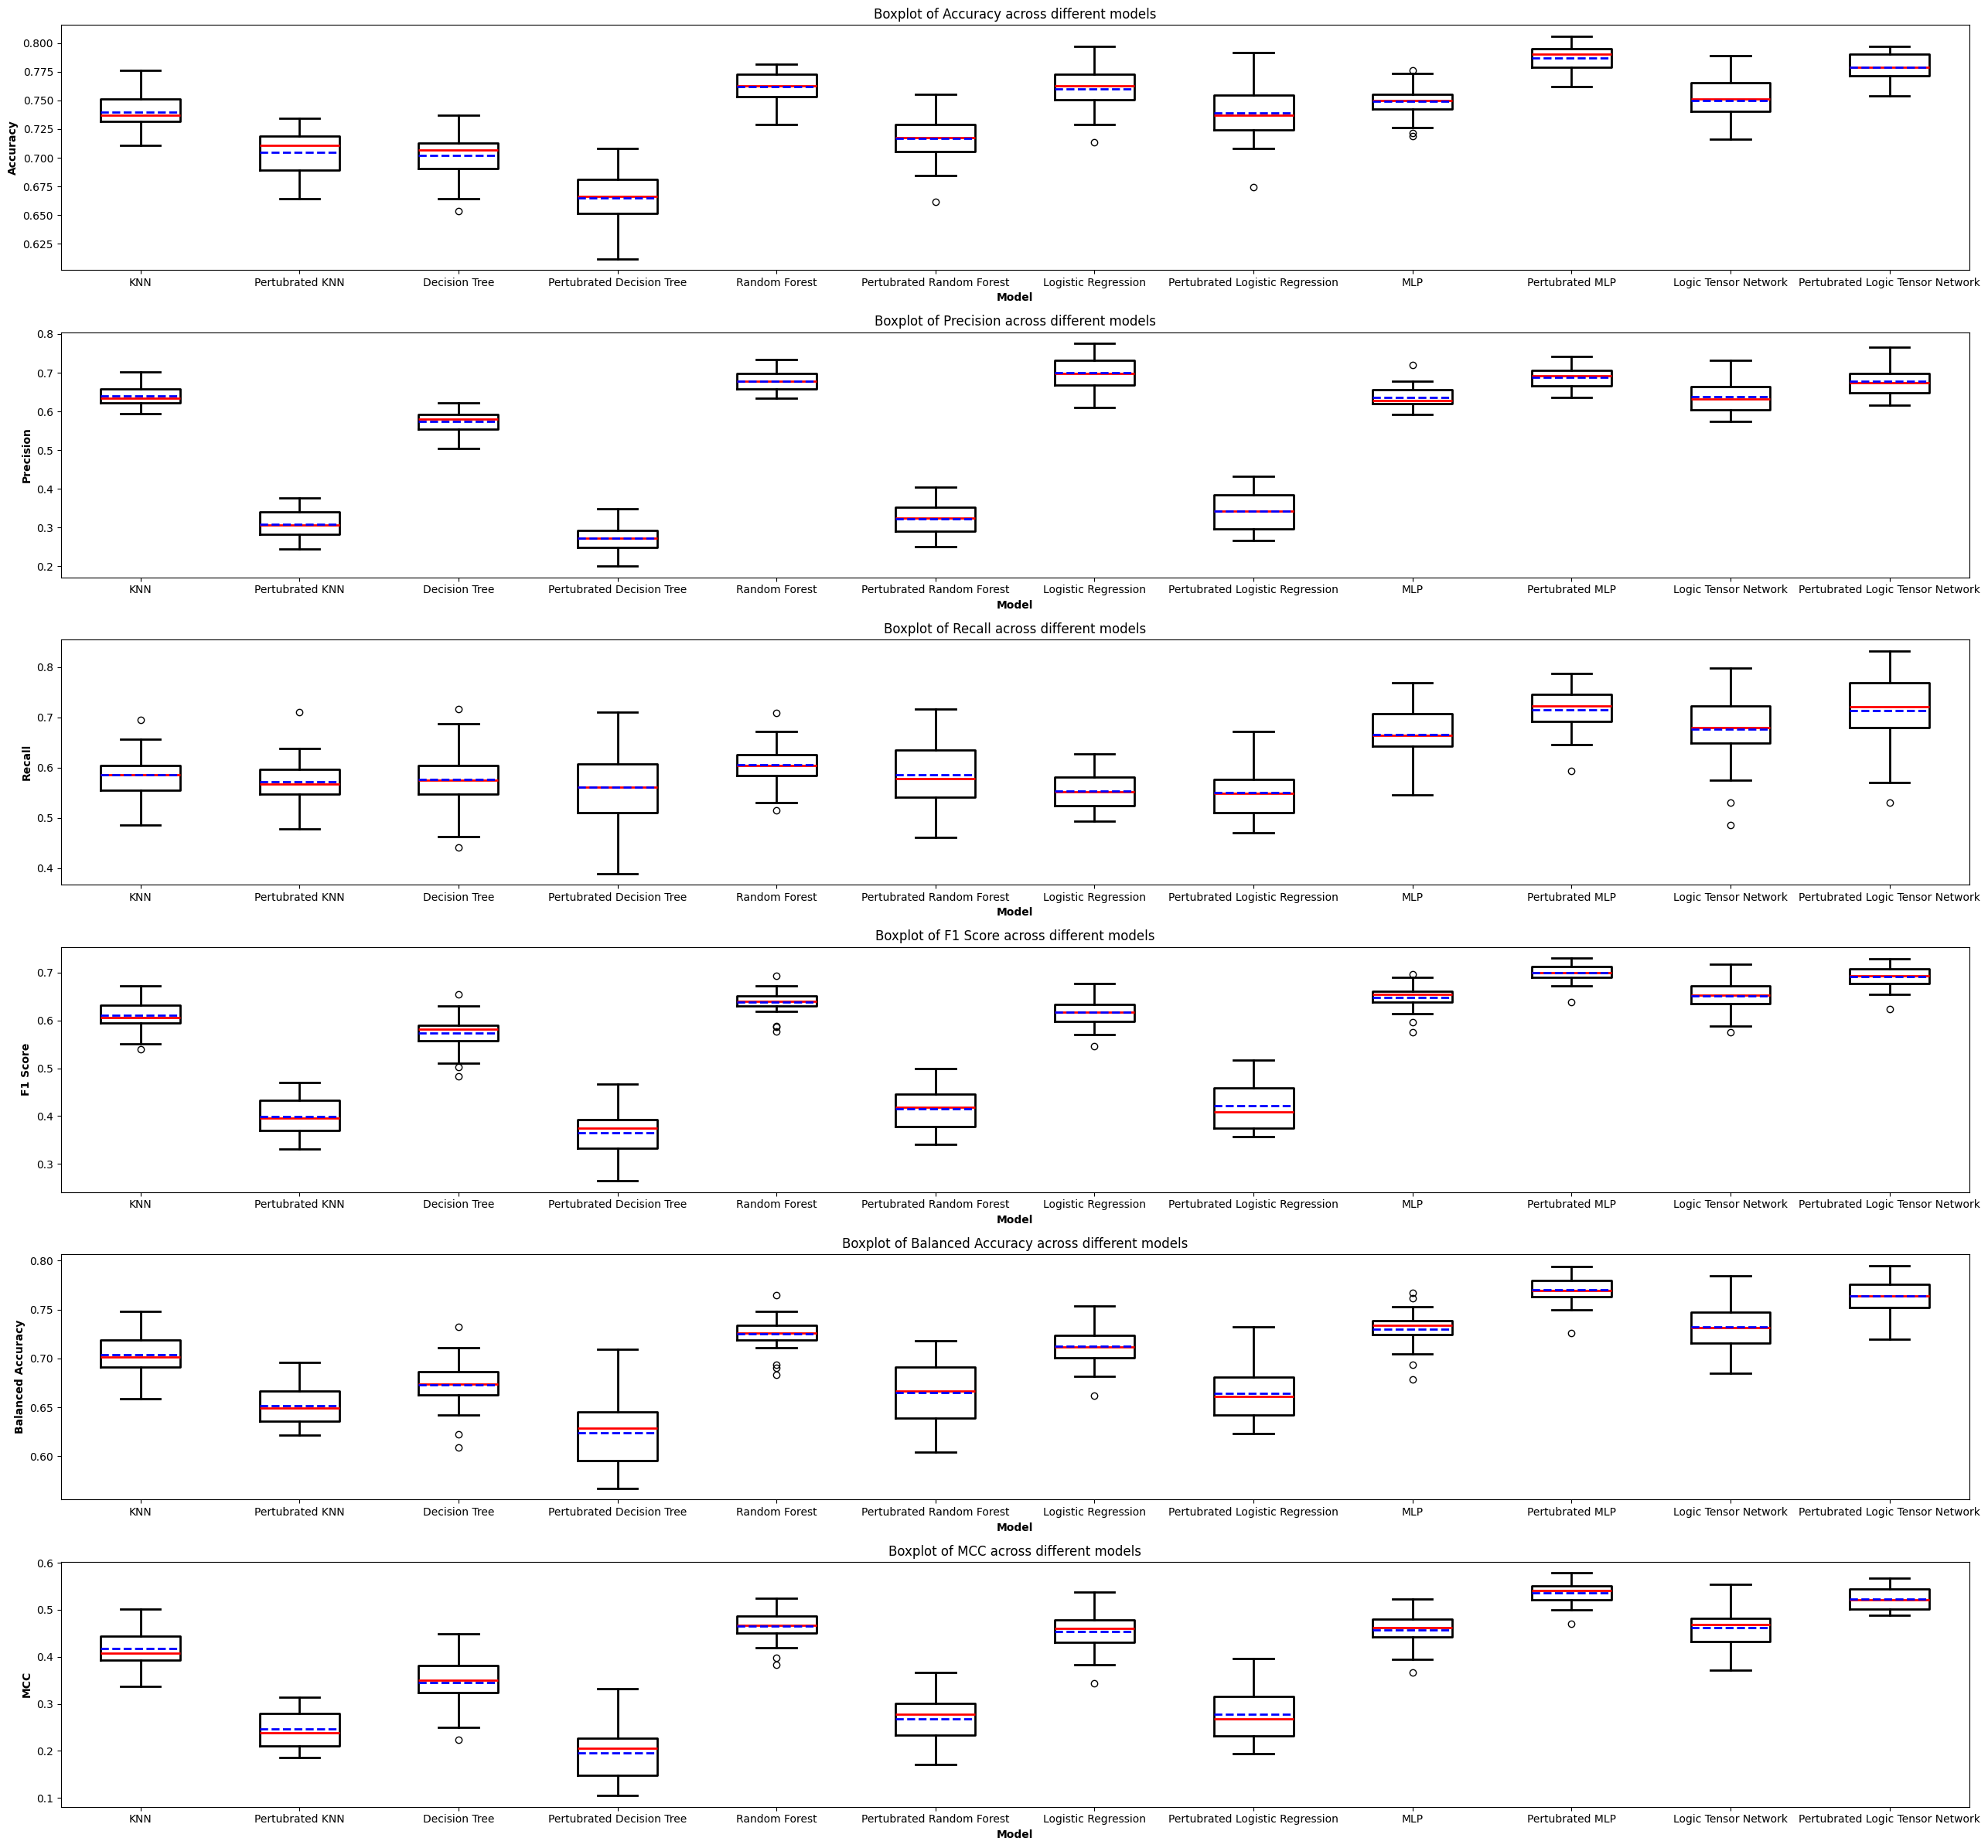

In [29]:
metrics_df.index = model_names
perturbed_df.index = pertubrated_names

models = []

for name in model_names:
    models.append(name)
    models.append("Pertubrated " + name)

all_models = pd.concat([metrics_df, perturbed_df]).loc[models]
plot_metrics(all_models, metrics, x_size=26)

In [30]:
compare_models(perturbed_df)


Accuracy:
  Pertubrated MLP is significantly better than Pertubrated KNN (adjusted p = 0.0000)
  Pertubrated MLP is significantly better than Pertubrated Decision Tree (adjusted p = 0.0000)
  Pertubrated MLP is significantly better than Pertubrated Random Forest (adjusted p = 0.0000)
  Pertubrated MLP is significantly better than Pertubrated Logistic Regression (adjusted p = 0.0000)
  Pertubrated MLP is significantly better than Pertubrated Logic Tensor Network (adjusted p = 0.0043)

Precision:
  Pertubrated MLP is significantly better than Pertubrated KNN (adjusted p = 0.0000)
  Pertubrated MLP is significantly better than Pertubrated Decision Tree (adjusted p = 0.0000)
  Pertubrated MLP is significantly better than Pertubrated Random Forest (adjusted p = 0.0000)
  Pertubrated MLP is significantly better than Pertubrated Logistic Regression (adjusted p = 0.0000)
  Pertubrated MLP is NOT significantly better than Pertubrated Logic Tensor Network (adjusted p = 0.1066)

Recall:
  Pertub